In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import psutil, sys, gc
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets,linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
# 定義函數以便執行肩並肩的列印
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

讀檔

#### 查看資料分布狀況

資料是否重複

In [4]:
bikeHourDF.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
17374    False
17375    False
17376    False
17377    False
17378    False
Length: 17379, dtype: bool

In [6]:
bikeHourDF.info() #查看有無空值以及資料型態

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rec_id             17379 non-null  int64  
 1   datetime           17379 non-null  object 
 2   season             17379 non-null  int64  
 3   year               17379 non-null  int64  
 4   month              17379 non-null  int64  
 5   hour               17379 non-null  int64  
 6   is_holiday         17379 non-null  int64  
 7   weekday            17379 non-null  int64  
 8   is_workingday      17379 non-null  int64  
 9   weather_condition  17379 non-null  int64  
 10  temp               17379 non-null  float64
 11  atemp              17379 non-null  float64
 12  humidity           17379 non-null  float64
 13  windspeed          17379 non-null  float64
 14  casual             17379 non-null  int64  
 15  registered         17379 non-null  int64  
 16  total_count        173

In [7]:
bikeHourDF.sample(5)

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
1620,1621,2011-03-13,1,0,3,0,0,0,0,1,0.38,0.3939,0.62,0.1045,3,35,38
4411,4412,2011-07-07,3,0,7,17,0,4,1,1,0.86,0.7576,0.36,0.2537,80,489,569
15843,15844,2012-10-27,4,1,10,8,0,6,0,1,0.50,0.4848,0.77,0.2537,26,187,213
15461,15462,2012-10-11,4,1,10,10,0,4,1,1,0.44,0.4394,0.41,0.3582,39,165,204
821,822,2011-02-06,1,0,2,16,0,0,0,1,0.34,0.3485,0.49,0.1045,42,115,157


#### 刪除不必要的類別

觀察 相關係數

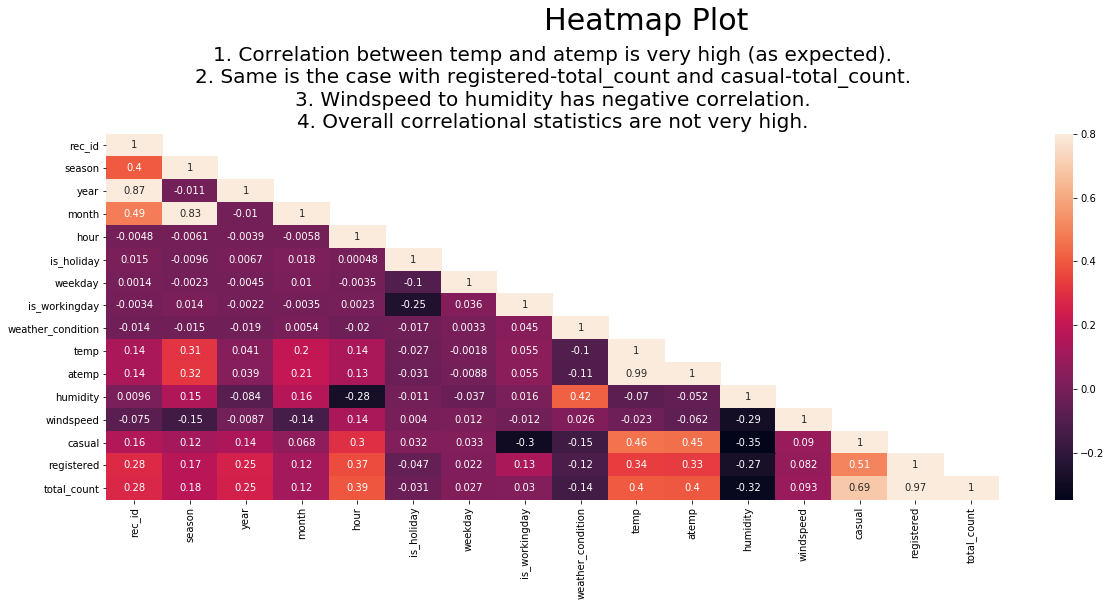

In [8]:
fig,ax = plt.subplots(figsize=(20,8))
fig.suptitle("Heatmap Plot", fontsize=30)
fig.subplots_adjust(top=0.76) 
ax.set_title("1. Correlation between temp and atemp is very high (as expected).\n"+
             "2. Same is the case with registered-total_count and casual-total_count.\n"+
             "3. Windspeed to humidity has negative correlation.\n"+
             "4. Overall correlational statistics are not very high.", fontsize=20)
corrcoef = bikeHourDF.corr()
mask = np.array(corrcoef)
mask[np.tril_indices_from(mask)] = False
# sns.heatmap(corrcoef, mask=mask, vmax=.8, square=True, annot=True, ax=ax)
sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
plt.show();

觀察到atemp 和 temp 相關係數為0.99，故刪除atemp 數據

In [9]:
bikeHourDF=bikeHourDF.drop(['atemp'],axis=1)

由於所有使用者的租賃數量是由未註冊使用者和註冊使用者相加而成，故刪除

In [10]:
bikeHourDF=bikeHourDF.drop(['casual','registered'],axis=1)

### 觀察數據

#### 觀察hour和total_count的關係

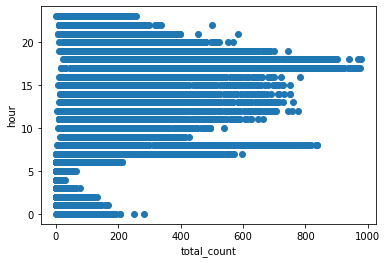

In [11]:
X = bikeHourDF['total_count']
Y = bikeHourDF['hour'] 
regr=linear_model.LinearRegression()
plt.xlabel('total_count')
plt.ylabel('hour')
model = LinearRegression(fit_intercept=True)
model.fit(X[:, np.newaxis], Y)
plt.scatter(X, Y)

顯示 pm5:00-6:00 和 am 7:00-8:00是借用高峰

#### 觀察month 和 total_count的關係

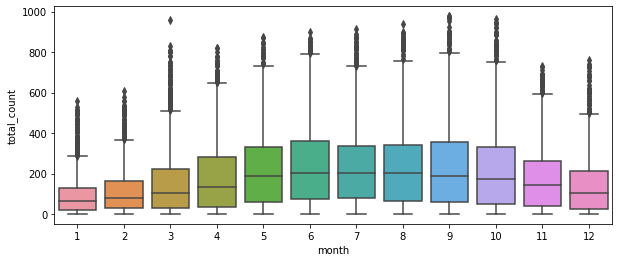

In [12]:
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.boxplot(x='month', y='total_count', data=bikeHourDF)
plt.show()

發現 6789月份 借出量較高

#### season and total_count 

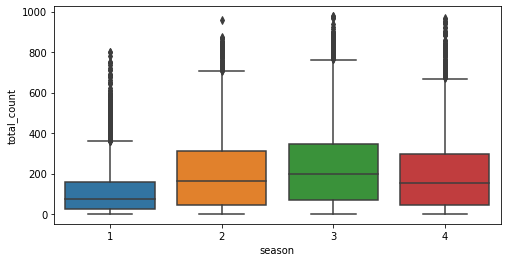

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='season', y='total_count', data=bikeHourDF)
plt.show()

發現 以中位數來說，秋季數量最多，春季最少

#### season month的關係

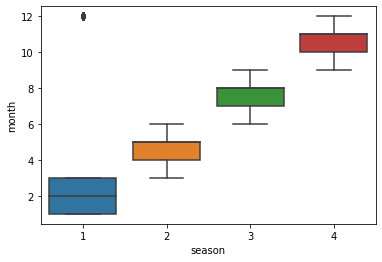

In [14]:
sns.boxplot(x='season', y='month',data=bikeHourDF)

season 是由 month 推估而來 ，如照緯度來看，跟台灣一樣:123為春季456為夏季...

觀察temp與season的關係，發現春季的氣溫中位數較冬季氣溫中位數高
故新增 group_season,調整月分和季節的數值

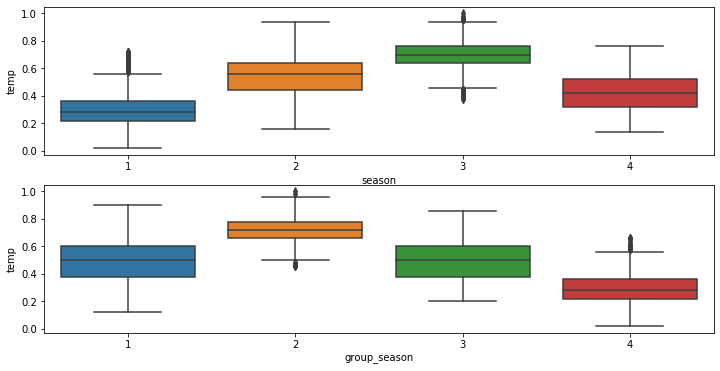

In [15]:
bikeHourDF['group_season'] = np.where((bikeHourDF.month <=5) & (bikeHourDF.month >=3), 1,
                        np.where((bikeHourDF.month <=8) & (bikeHourDF.month >=6), 2,
                                 np.where((bikeHourDF.month <=11) & (bikeHourDF.month >=9), 3, 4)))
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
#繪製氣溫和季節箱線圖
sns.boxplot(x='season', y='temp',data=bikeHourDF, ax=ax[0])
sns.boxplot(x='group_season', y='temp',data=bikeHourDF, ax=ax[1])

##### 觀察 group_season 與 total_count的關係
發現在夏秋兩季，total_count較高

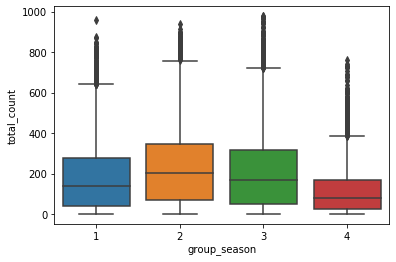

In [16]:
sns.boxplot(x='group_season', y='total_count',data=bikeHourDF)

In [17]:
bikeHourDF['group_season'].sample(5)

13896    2
11665    1
12950    2
1472     1
15402    3
Name: group_season, dtype: int64

第二章圖較為合理，故刪除原本season之數據

In [18]:
bikeHourDF.drop(['season'],axis=1)
bikeHourDF.shape

(17379, 15)

#### year and total_count

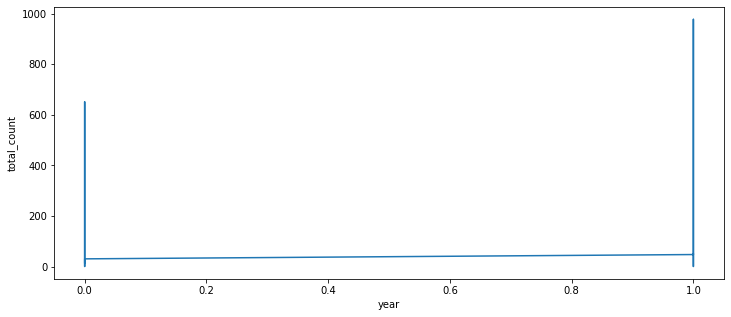

In [19]:
plt.figure(figsize=(12,5))
x=bikeHourDF['total_count']
y=bikeHourDF['year']
plt.plot(y,x)
plt.ylabel('total_count')
plt.xlabel('year')
plt.show()

#### is_holiday and total_count

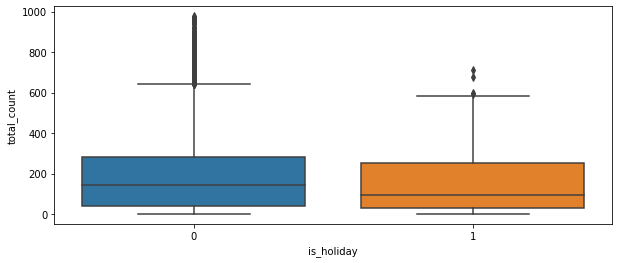

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.boxplot(x='is_holiday', y='total_count', data=bikeHourDF)
plt.show()

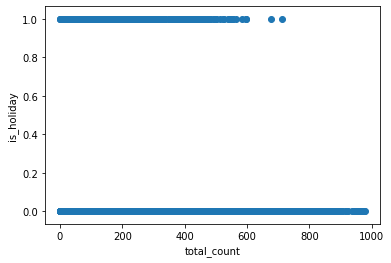

In [21]:
X = bikeHourDF['total_count']
Y = bikeHourDF['is_holiday'] 
regr=linear_model.LinearRegression()
plt.xlabel('total_count')
plt.ylabel('is_holiday')
model = LinearRegression(fit_intercept=True)
model.fit(X[:, np.newaxis], Y)
plt.scatter(X, Y)

工作日total_count較多，假日較少 

#### 其他變數和total_count的關係
剩餘變數 temp humidity windspeed 

In [22]:
bikeHourDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rec_id             17379 non-null  int64  
 1   datetime           17379 non-null  object 
 2   season             17379 non-null  int64  
 3   year               17379 non-null  int64  
 4   month              17379 non-null  int64  
 5   hour               17379 non-null  int64  
 6   is_holiday         17379 non-null  int64  
 7   weekday            17379 non-null  int64  
 8   is_workingday      17379 non-null  int64  
 9   weather_condition  17379 non-null  int64  
 10  temp               17379 non-null  float64
 11  humidity           17379 non-null  float64
 12  windspeed          17379 non-null  float64
 13  total_count        17379 non-null  int64  
 14  group_season       17379 non-null  int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 2.0+ MB


#### 將我們認為有高度相關的數值提出:
hour,month,year,group_season,is_holiday,is_workingday,weather_condition,humidity

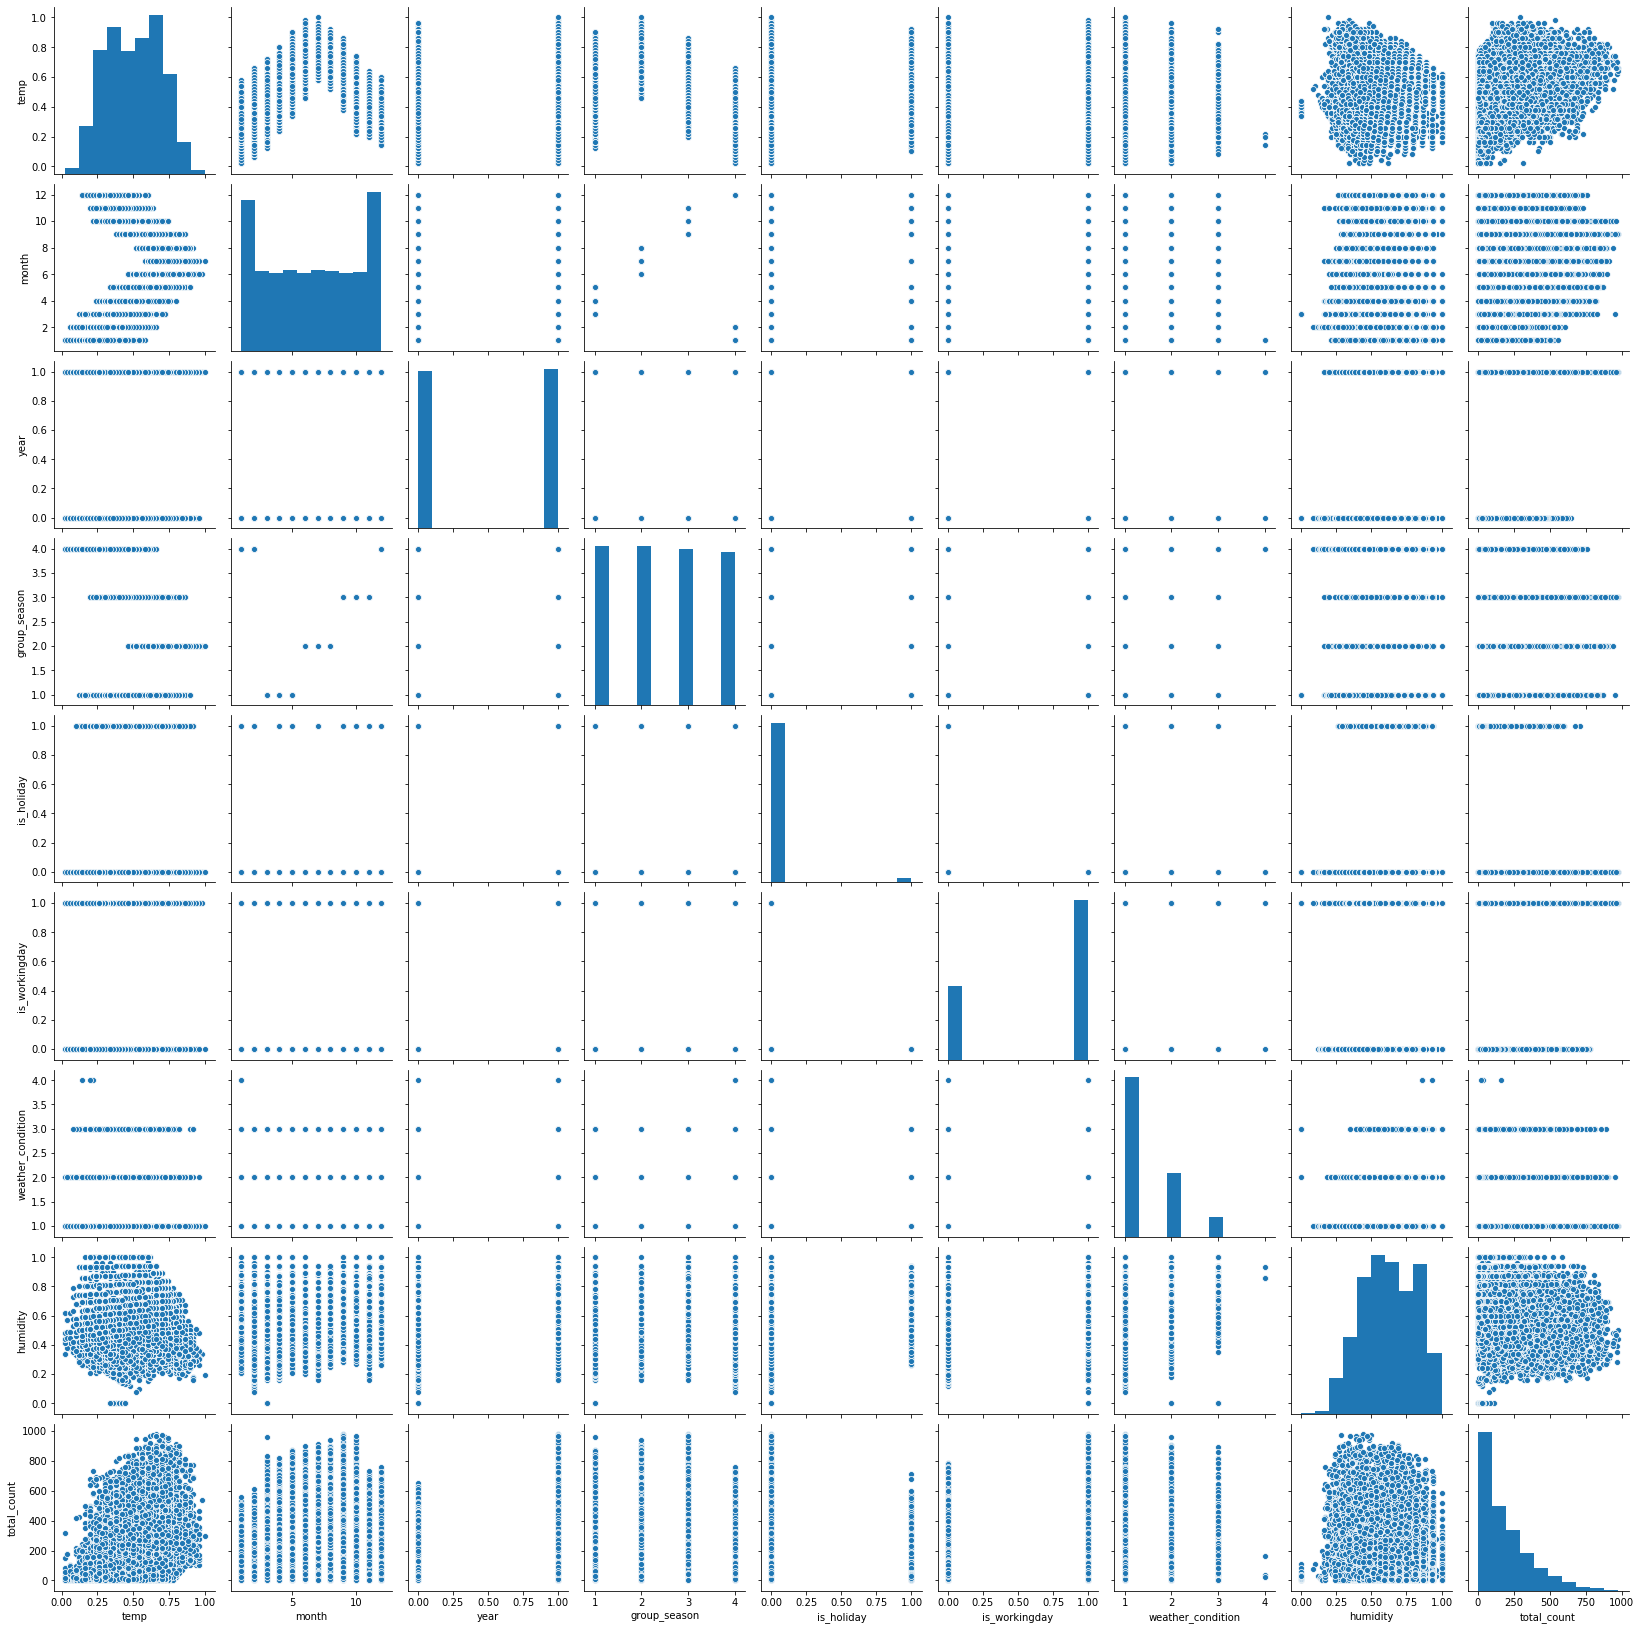

In [23]:
sns.pairplot(bikeHourDF[['temp','month','year','group_season','is_holiday','is_workingday','weather_condition','humidity','total_count']])

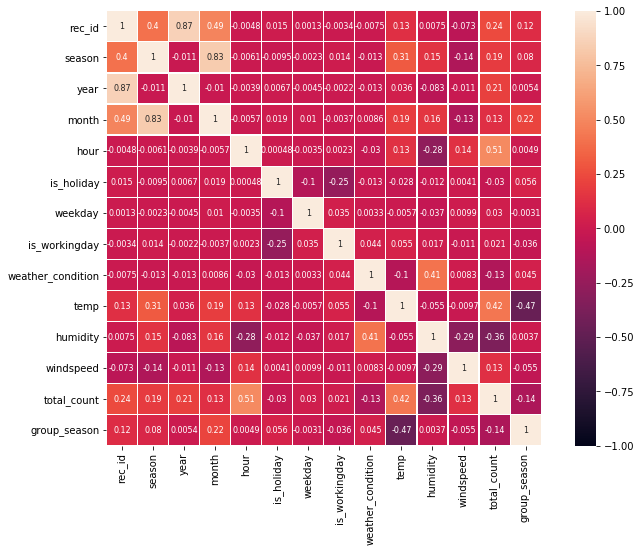

In [24]:
pic=bikeHourDF[['temp','month','year','group_season','is_holiday','is_workingday','weather_condition','humidity','total_count']]
correlation = bikeHourDF.corr(method='spearman')
plt.figure(figsize=(12, 8))
#繪製熱力圖
sns.heatmap(correlation, linewidths=0.2, vmax=1, vmin=-1, linecolor='w',
            annot=True,annot_kws={'size':8},square=True)

In [1]:
t_data

NameError: name 't_data' is not defined

### 不處理資料 直接回歸模型


In [47]:
from sklearn.model_selection import train_test_split
# if you wish to get the same results for running train_test_split at each time, please set a value for random_states.
# we select all input featues except 'casual', 'registered', the total_count is our target variable
t_data = bikeHourDF.drop(['total_count','datetime'],axis=1) 

trainData, testData, trainTarget, testTarget = train_test_split(t_data, bikeHourDF['total_count'], 
                                                                test_size=0.5, random_state=22)
side_by_side("Training set: data:{} and target:{}".format(trainData.shape,trainTarget.shape),
             "Testing set: data:{} and target:{}".format(testData.shape,testTarget.shape))

'Training set: data:(8689, 13) and target:(8689,)'    'Testing set: data:(8690, 13) and target:(8690,)'



In [48]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(trainData,trainTarget)
LR.score(testData,testTarget)

0.38596906304750167

由結果可知 數據需降維 才能增加回歸係數

### 回歸模型

In [25]:
bikeTest= bikeHourDF.copy()

In [26]:
bikeTest=bikeTest.drop(['rec_id','datetime','season','weekday','windspeed'],axis=1)

In [27]:
bikeTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               17379 non-null  int64  
 1   month              17379 non-null  int64  
 2   hour               17379 non-null  int64  
 3   is_holiday         17379 non-null  int64  
 4   is_workingday      17379 non-null  int64  
 5   weather_condition  17379 non-null  int64  
 6   temp               17379 non-null  float64
 7   humidity           17379 non-null  float64
 8   total_count        17379 non-null  int64  
 9   group_season       17379 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


In [28]:
bikeTest.sample(5)

,year,month,hour,is_holiday,is_workingday,weather_condition,temp,humidity,total_count,group_season
8936,1,1,5,0,1,2,0.30,0.70,21,4
8364,0,12,4,0,1,2,0.36,0.53,4,4
5024,0,8,6,0,1,1,0.68,0.69,117,2
3746,0,6,0,0,1,3,0.70,0.65,69,2
3563,0,6,9,0,1,1,0.72,0.26,225,2


### 資料前處理
固定項目之值，ex mouth hour weather_condition
變成 0 1 型態(is_workingday 和 is_holiday已是0 1型態)

##### hour轉換

In [29]:
dataHour = pd.get_dummies(bikeTest['hour'])
pd.DataFrame(dataHour)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
17375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


##### month轉換

月份(1-12)變成當月數據(1)不是當月數據(0)

In [30]:
dataMonth = pd.get_dummies(bikeTest['month'])
pd.DataFrame(dataMonth)

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0,0,0,0,0,0,0,0,0,0,0,1
17375,0,0,0,0,0,0,0,0,0,0,0,1
17376,0,0,0,0,0,0,0,0,0,0,0,1
17377,0,0,0,0,0,0,0,0,0,0,0,1


##### year 轉換

In [31]:
dataYear = pd.get_dummies(bikeTest['year'])
pd.DataFrame(dataYear)

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
17374,0,1
17375,0,1
17376,0,1
17377,0,1


##### group_season 轉換

In [32]:
dataGroup_season = pd.get_dummies(bikeTest['group_season'])
pd.DataFrame(dataGroup_season)

,1,2,3,4
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
17374,0,0,0,1
17375,0,0,0,1
17376,0,0,0,1
17377,0,0,0,1


##### weather_condition轉換

In [33]:
dataWeather_condition = pd.get_dummies(bikeTest['weather_condition'])
pd.DataFrame(dataWeather_condition)

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
17374,0,1,0,0
17375,0,1,0,0
17376,1,0,0,0
17377,1,0,0,0


In [34]:
bikeTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               17379 non-null  int64  
 1   month              17379 non-null  int64  
 2   hour               17379 non-null  int64  
 3   is_holiday         17379 non-null  int64  
 4   is_workingday      17379 non-null  int64  
 5   weather_condition  17379 non-null  int64  
 6   temp               17379 non-null  float64
 7   humidity           17379 non-null  float64
 8   total_count        17379 non-null  int64  
 9   group_season       17379 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


#### 定義colunms 放入bikeTest中

In [35]:
columns = ['humidity','temp','is_holiday','is_workingday']+list(dataYear)+list(dataHour)+list(dataMonth)+list(dataGroup_season) + list(dataWeather_condition)
columns

['humidity',
 'temp',
 'is_holiday',
 'is_workingday',
 0,
 1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 4]

#### pd.concat 合併資料
將轉換過後的 dataMonth,dataWeather_condition,dataHour放入

In [38]:
bikeTest= pd.concat([bikeHourDF,dataMonth,dataWeather_condition,dataHour], axis=1)
bikeTest.sample(5)

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,...,14,15,16,17,18,19,20,21,22,23
14868,14869,2012-09-16,3,1,9,17,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5082,5083,2011-08-04,3,0,8,16,0,4,1,1,...,0,0,1,0,0,0,0,0,0,0
10363,10364,2012-03-12,1,1,3,22,0,1,1,2,...,0,0,0,0,0,0,0,0,1,0
14256,14257,2012-08-22,3,1,8,5,0,3,1,1,...,0,0,0,0,0,0,0,0,0,0
15385,15386,2012-10-08,4,1,10,6,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### 建立回歸模型
test 和 train兩組
trainData為 column項，testData為total_count

In [39]:
x=bikeTest[columns]
y=bikeTest['total_count']

In [40]:
trainData, testData, trainTarget, testTarget = train_test_split(x, y, 
                                                                test_size=0.4, random_state=1001)
side_by_side("Training set: data:{} and target:{}".format(trainData.shape,trainTarget.shape),
             "Testing set: data:{} and target:{}".format(testData.shape,testTarget.shape))

'Training set: data:(10427, 100) and target:(10427,)'    'Testing set: data:(6952, 100) and target:(6952,)'



#### 計算出 迴歸係數

In [41]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(trainData,trainTarget)
LR.score(testData,testTarget)

0.628323857502501

In [42]:
D_predict=LR.predict(testData)
D_predict

array([251.1875   , 443.46875  , 329.6640625, ...,  12.3046875,
        25.6171875, -21.96875  ])

In [43]:
def residualPlot(y, yPred, r2Avg):
    fig, ax = plt.subplots(figsize=(30,10)) 
    fig.suptitle("Residual Plot", fontsize=32)
    fig.subplots_adjust(top=0.75) 
    ax.set_title("1. The normality assumption for linear regression applies to the errors\n"+
                 "2. The usual statement is that the errors are i.i.d. as Normal with a mean of 0 and some variance.\n"+
                 "3. Besides, independence and homoscedasticity are more important assumptions than normality.\n"+
                 "4. Residual Plot with Average R-Squared={:.4f}".format(r2Avg), fontsize=28)
    ax.scatter(y, y-yPred) 
    ax.axhline(lw=6,color='red')
    ax.set_xlabel('Observed', fontsize=24)
    ax.set_ylabel('Residual(Error)', fontsize=24)
    plt.show()

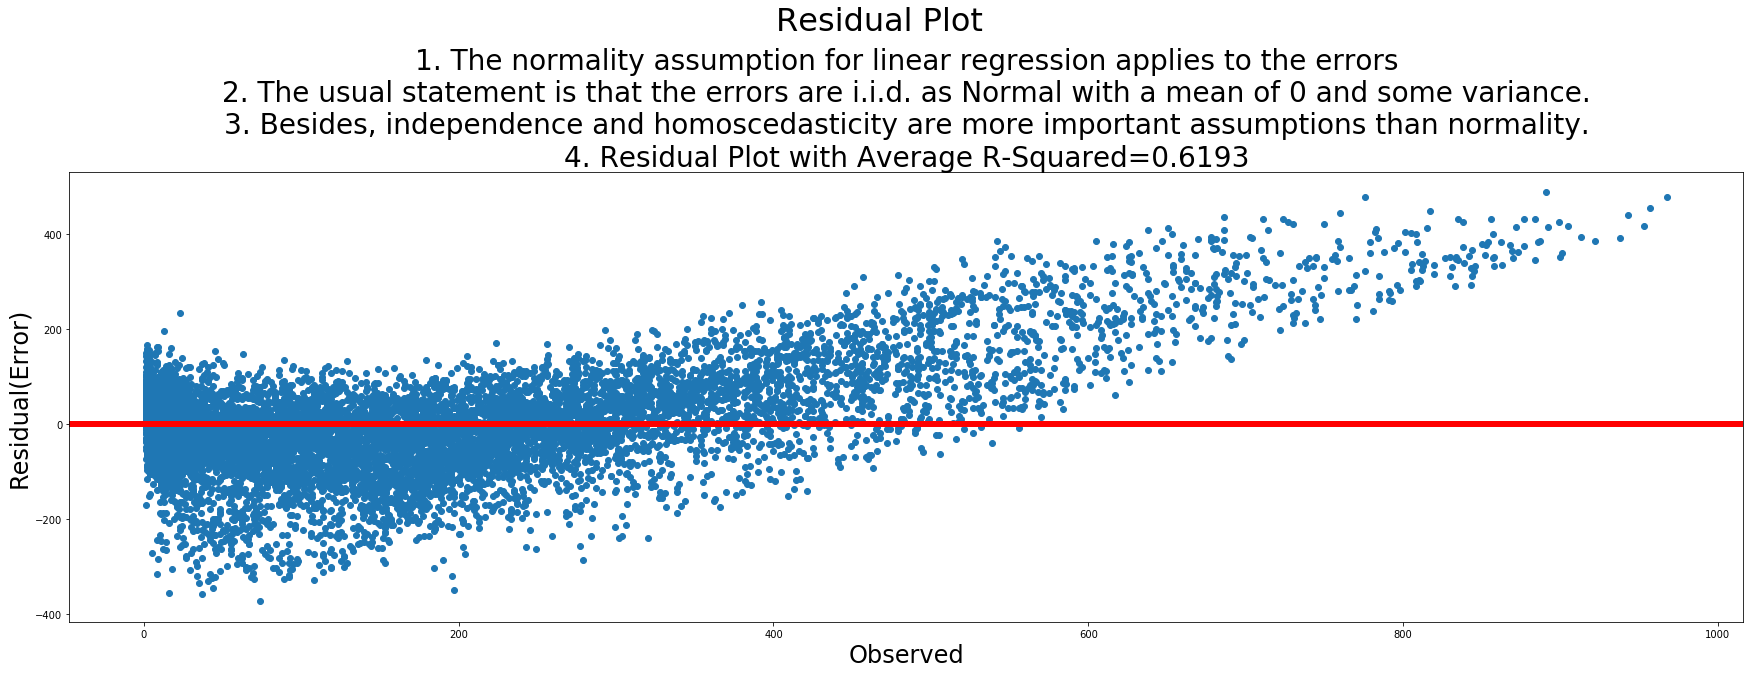

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
linReg=LinearRegression()
predicted = cross_val_predict(linReg,trainData,trainTarget,cv=10)
r2AvgTrainLR = np.average(cross_val_score(linReg, trainData, trainTarget, cv=10))
residualPlot(trainTarget, predicted, r2AvgTrainLR)

### 作業發現與心得

    這次的做作業，會發現平時我們自己做的練習明顯不夠。在完成作業中，時常要額外上網查資料，甚至是跟別組做討論，才能完成這次的作業。
    個人覺得這麼model漏洞百出，利用資料相關度整理數據、線性回歸完成modal。
    開始時，完全不知從何下手，去詢問助教後，才能夠抓到研究方向；其中也發現，我們在分尋分類中，遇到的瓶頸較大，想嘗試用PCA和SVD，卻一直都沒有成功，只能直接做線性回歸，和嘗試用one-hot處理數據，在進行迴歸分析；但簡單幾個步驟，我們遇到的錯誤卻是非常非常多的，要經過很多次的修改，甚至出現過大數值或是負數，都讓對這數據分析不熟悉的我們感到害怕，這也顯示了我們對數據和程式語法的不熟悉，勢必要多作自主訓練，建立對資料的直覺性。
 